# Jupyter Notebook for the Nutrien Challenge

This challenge was completed on Oct 22 from 9:30 to 1:30 MST

In [3]:
# Importing functions in the script
import yfinance as yf
import pandas as pd
import zipfile
from urllib.request import urlopen   
import io
import re
import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [5]:
# Updating colors of matplot lib to be the same as nutrien colors using the following datasource:
#https://www.nutrien.com/resources/logos_branding
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#4C9E00', '#226398', '#8C1D23', '#D47024', '#B8EDE2', '#465F70', '#E1BD5F', '#482B17', '#BEBEBE', '#828587', '#F1F0F2', '#DCDDDF', '#88D600'])

In [7]:
# Creating function to gather zipfile from statscan website
def gather_zipfile(url):    
    zf = zipfile.ZipFile(io.BytesIO(urlopen(url).read()))

    with zf.open("16100020.csv") as f:
          # read the dataset
          potash_production_data = pd.read_csv(f)
          
    return potash_production_data

In [8]:
# Creating formatting function for use in matplotlib to convert axis to millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

# Pulling Potash Production 
I could not find an API that supplied information that I wanted to use for this analysis. Instead of this, I pulled data directly from statscan using the function supplied above. This has the same effect as it does not rely on downloads.

In [9]:
# Pulling Potash Production 
url = r'https://www150.statcan.gc.ca/n1/tbl/csv/16100020-eng.zip'
potash_production_data = gather_zipfile(url = url)
potash_production_data.head()

,REF_DATE,GEO,DGUID,Products,Variables,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2020-01,Canada,2016A000011124,Diamonds (carats),Quantity produced,Carats,399,units,0,v1145997597,1.1.1,1316505.0,NaN,NaN,NaN,0
1,2020-01,Canada,2016A000011124,Diamonds (carats),Quantity shipped,Carats,399,units,0,v1145997613,1.1.2,1595510.0,NaN,NaN,NaN,0
2,2020-01,Canada,2016A000011124,Diamonds (carats),Value of shipments,Carats,399,units,0,v1146067292,1.1.3,NaN,..,NaN,NaN,0
3,2020-01,Canada,2016A000011124,Diamonds (carats),Closing inventories,Carats,399,units,0,v1145997629,1.1.4,1201337.0,NaN,NaN,NaN,0
4,2020-01,Canada,2016A000011124,Diamonds (dollars),Value of shipments,Dollars,81,units,0,v1145997965,1.2.3,137988684.0,NaN,NaN,NaN,0


## Filtering data to only include potash data

In [10]:
potash_production_data = potash_production_data[potash_production_data['Products'].str.contains("POTASH", flags=re.IGNORECASE, regex=True)]
# Filtering for only dollars, this is to discount the rise of commodity due to inflation
potash_production_data = potash_production_data[potash_production_data['UOM'] == 'Dollars']

# Choosing only value of shipments
potash_production_data = potash_production_data[potash_production_data['Variables'] == 'Value of shipments']

# Adding together potassium oxide and muriate of potash data
final_potash_production_data = potash_production_data.groupby(by=['REF_DATE', 'GEO'])['VALUE'].sum().reset_index()

## Creating stacked area plot
This plot is to see how much potash production is created by province

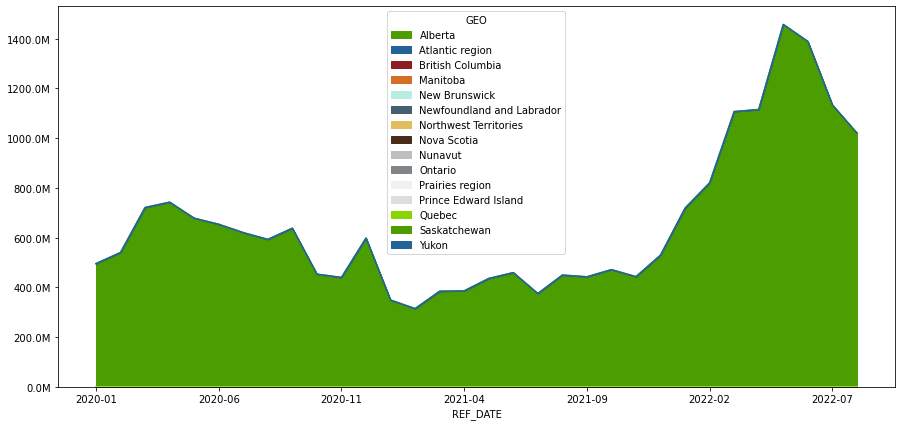

In [11]:
stacked_area_df = final_potash_production_data[final_potash_production_data['GEO'] != 'Canada']
stacked_area_df = stacked_area_df.pivot(index='REF_DATE', columns='GEO', values='VALUE')
formatter = FuncFormatter(millions)
ax = stacked_area_df.plot.area(figsize = (15, 7))
ax.yaxis.set_major_formatter(formatter)

It turns out all canadian potash is created in Saskatchewan... I could have guessed

## Updating dataframe
Based on analysis above, I updated the dataframe to only include canadian data and remove provincial values

In [12]:
final_potash_production_data = final_potash_production_data[final_potash_production_data['GEO'] == 'Canada']

# Determining year, month, day (assuming day is the first of each month)
final_potash_production_data['Year'] = final_potash_production_data['REF_DATE'].str.split('-').str[0].astype(int)
final_potash_production_data['Month'] = final_potash_production_data['REF_DATE'].str.split('-').str[1].astype(int)
final_potash_production_data['Day'] = 1

# Determining datetime so it will be plottable with the stock data
final_potash_production_data['Datetime'] = pd.to_datetime(final_potash_production_data[['Year', 'Month', 'Day']])

# Removing additional columns
final_potash_production_data = final_potash_production_data[['Datetime', 'VALUE']]

# Gathering Nutrien Stock Data
I used yahoo finance for this analysis and pulled stock data back 5 years

In [13]:
NTR_stock_data = yf.download(tickers='NTR', period='5y', interval='1d')

# Calculating rolling average to get a smoother plot with less noise
NTR_stock_data['Rolling_50'] = NTR_stock_data['Adj Close'].rolling(50).mean()

[*********************100%***********************]  1 of 1 completed


## Plotting Nutrien Stock Data

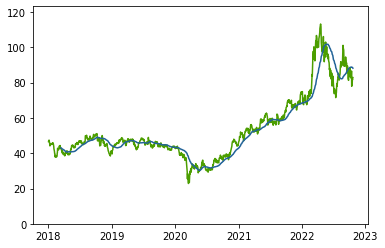

In [14]:
fig, ax = plt.subplots()
ax.plot(NTR_stock_data['Adj Close'])
ax.plot(NTR_stock_data['Rolling_50'])
ax.set_ylim(0, max(NTR_stock_data['Adj Close']) + 10)
plt.show()

# Plotting Nutrien Stock Data and Potash Production Together

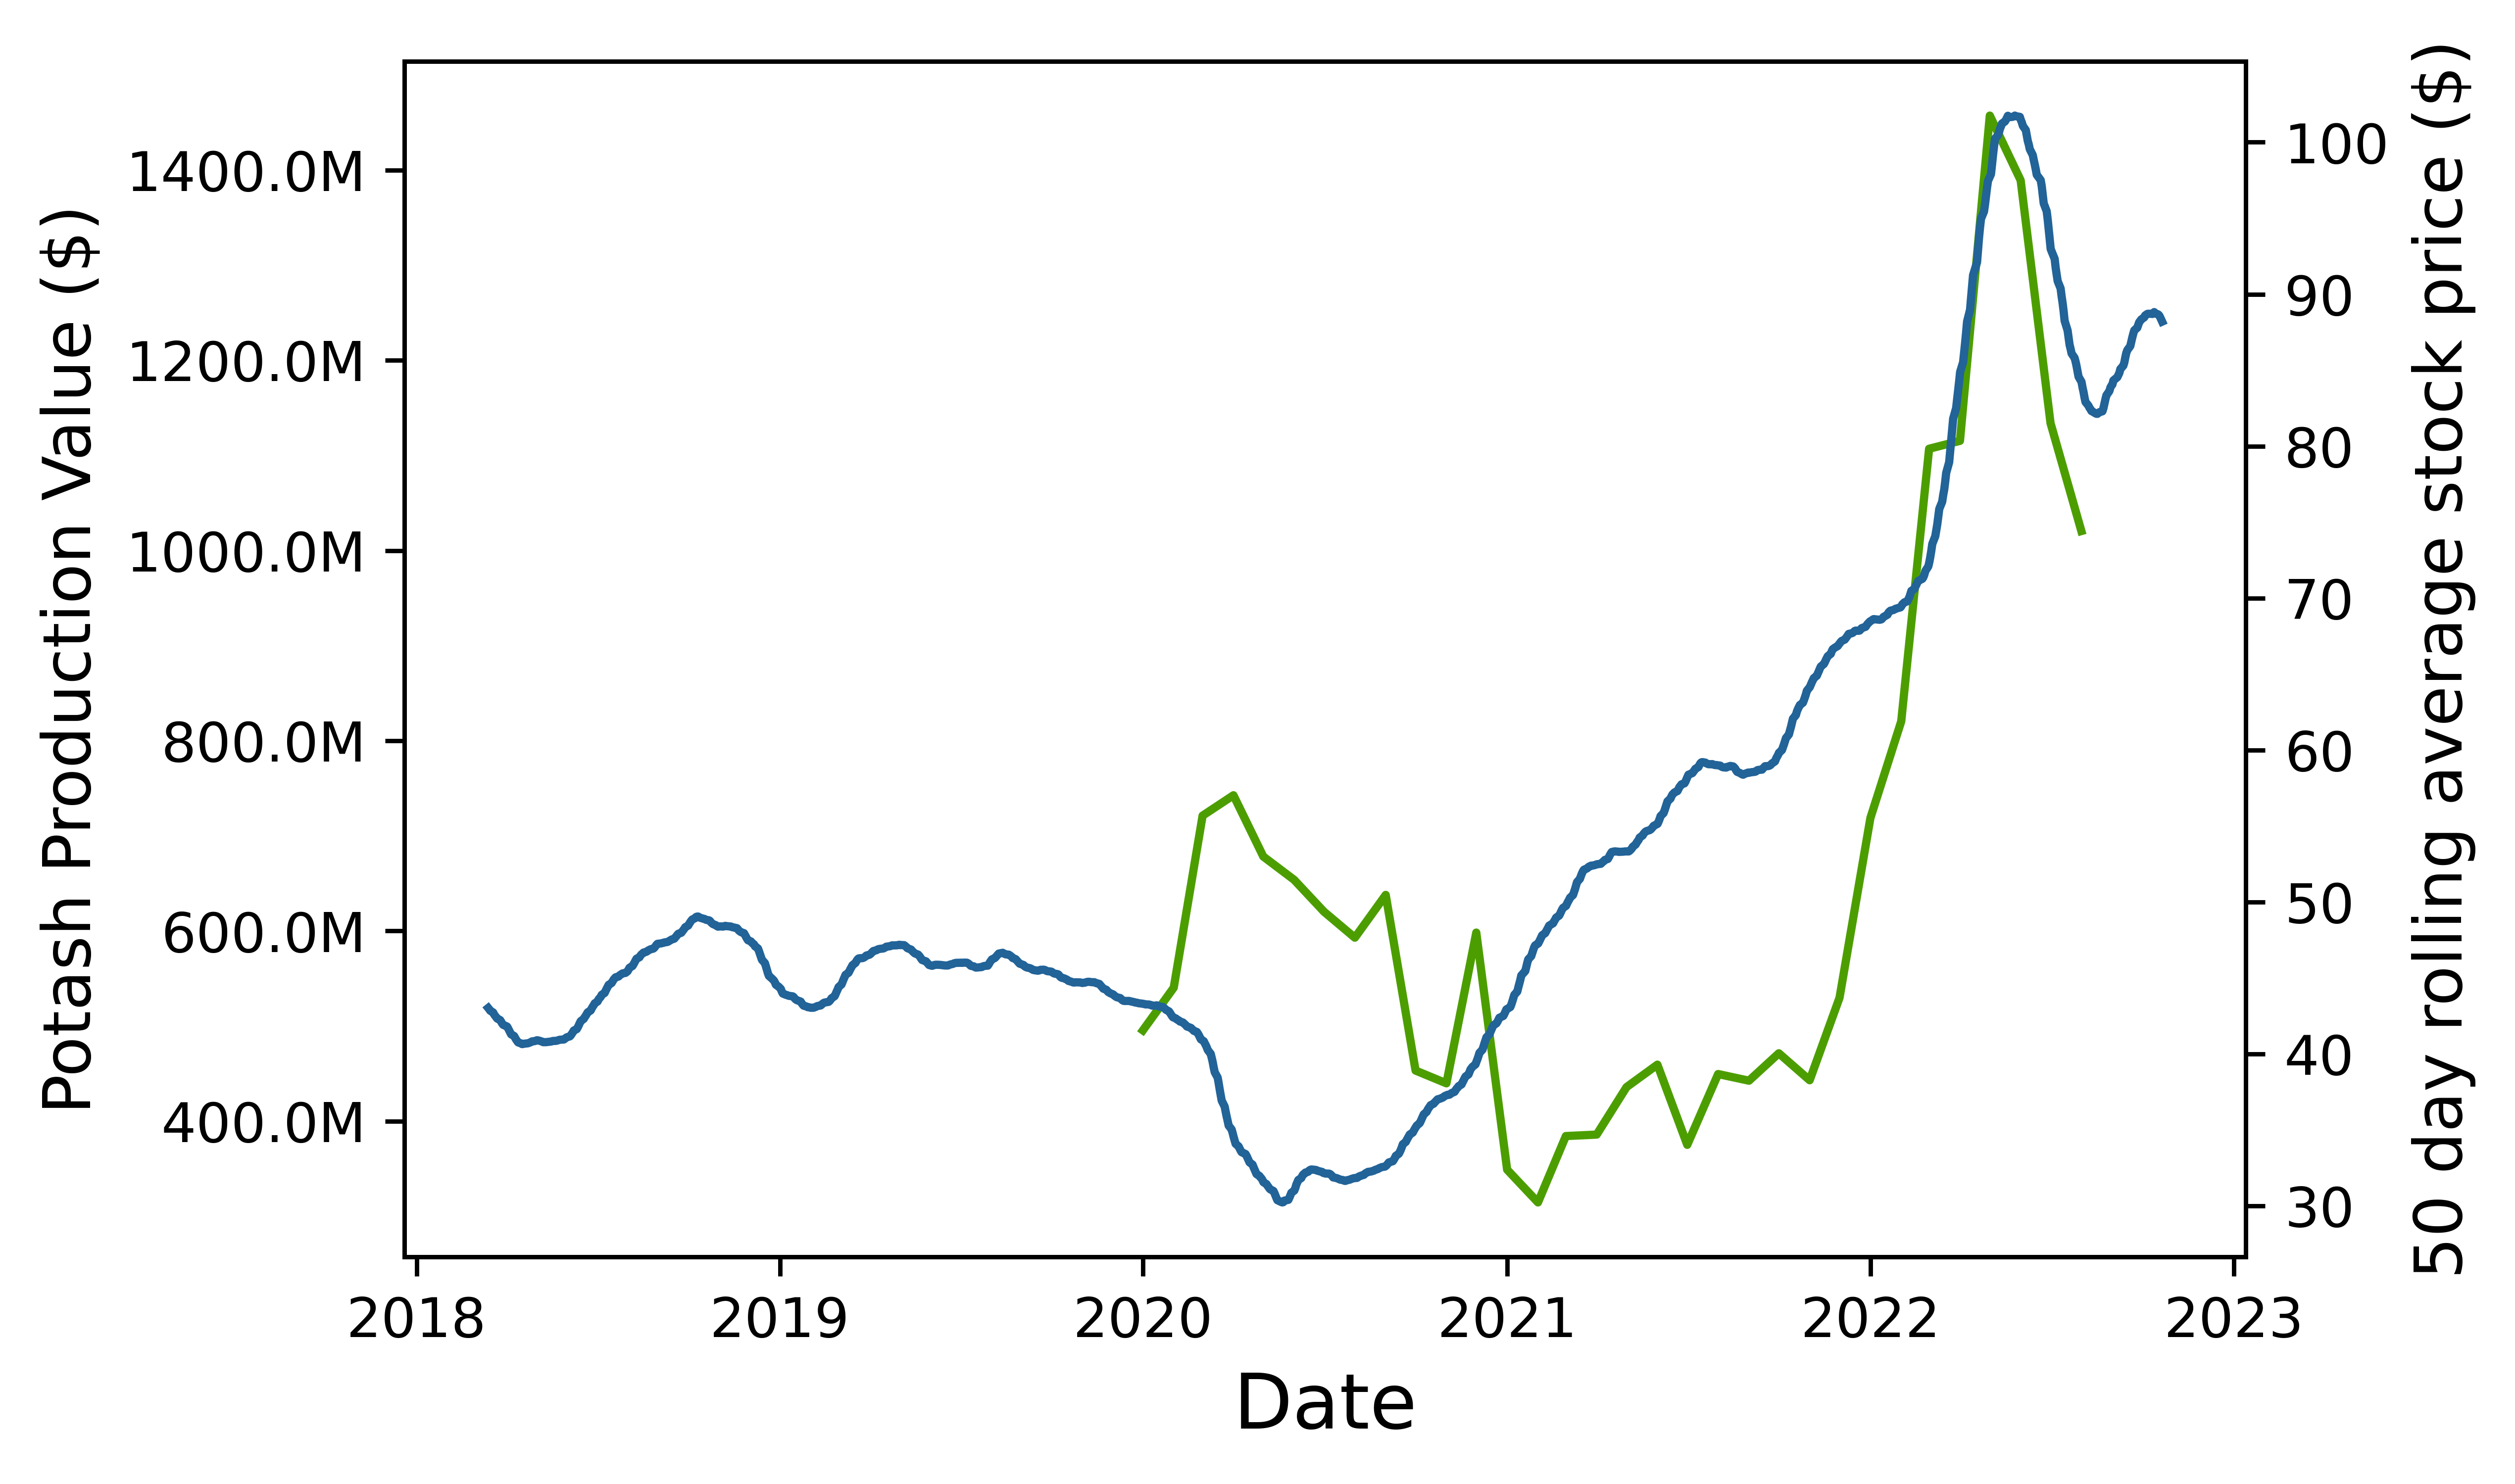

In [15]:
fig,ax = plt.subplots(dpi=800)
ax.plot(final_potash_production_data['Datetime'], final_potash_production_data['VALUE'])

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Potash Production Value ($)', fontsize=12)

# formatting
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
ax2.plot(NTR_stock_data.index, NTR_stock_data['Rolling_50'], color = '#226398')
ax2.set_ylabel('50 day rolling average stock price ($)', fontsize=12)
plt.show()

# General Data Exploration and Power BI

## Exporting DataFrame for use in Power BI

In [16]:
# Reformatting date as pandas is not able to export the current date format
NTR_stock_data = NTR_stock_data.reset_index()
NTR_stock_data['Date'] = pd.to_datetime(NTR_stock_data['Date']).dt.date

NTR_stock_data.to_excel(r'C:\Users\austi\OneDrive\Documents\GitHub\NutrienChallenge\Data\NTR_Stock_Data.xlsx')

## General Data Exploration
Since the data was simple and did not have much to correlate, I spent less time on the data exploration and analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     32 non-null     int64         
 1   Datetime  32 non-null     datetime64[ns]
 2   VALUE     32 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 896.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       1211 non-null   int64  
 1   Date        1211 non-null   object 
 2   Open        1211 non-null   float64
 3   High        1211 non-null   float64
 4   Low         1211 non-null   float64
 5   Close       1211 non-null   float64
 6   Adj Close   1211 non-null   float64
 7   Volume      1211 non-null   int64  
 8   Rolling_50  1162 non-null   float64
dtypes: float64(6), int64(2), object(

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>],
       [<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Adj Close'}>,
        <AxesSubplot:title={'center':'Volume'}>],
       [<AxesSubplot:title={'center':'Rolling_50'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

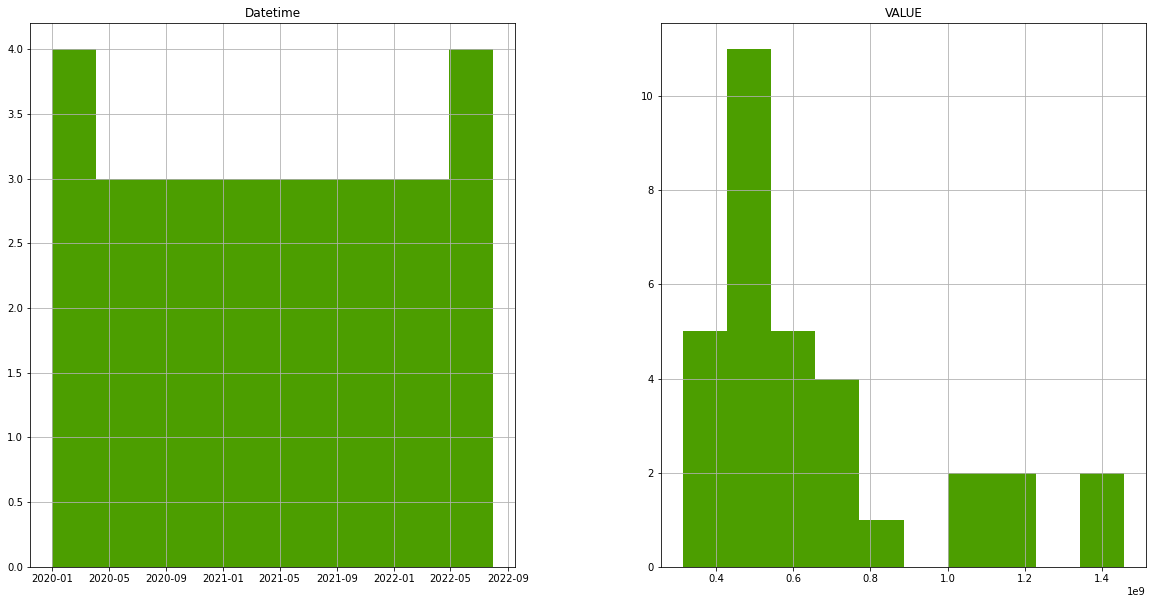

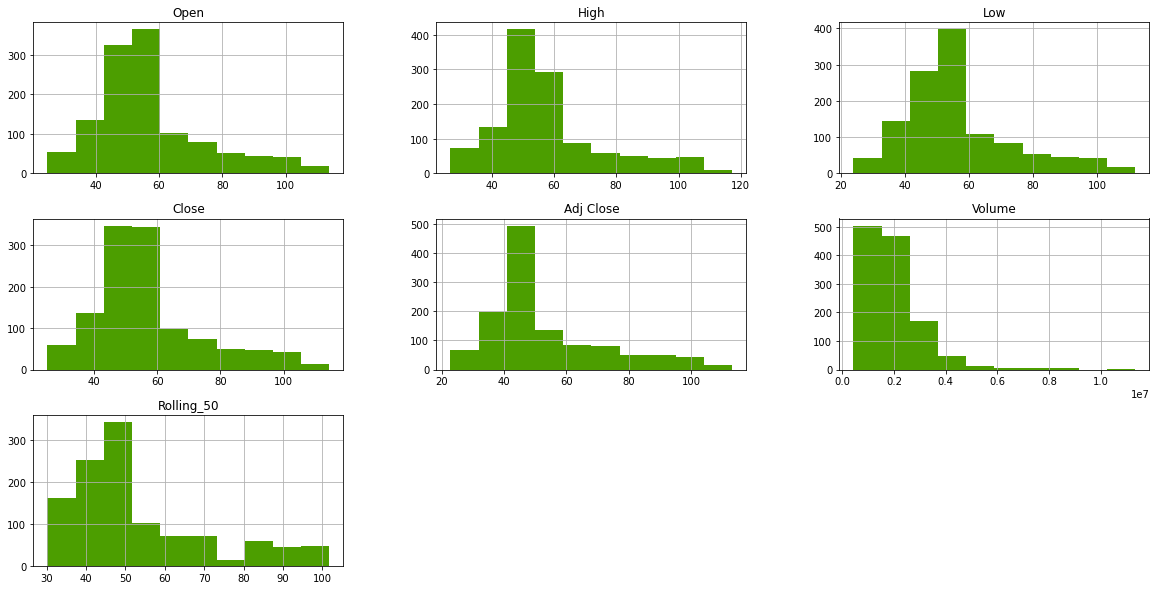

In [17]:
# Gathering general dataset information
final_potash_production_data.reset_index().info()
NTR_stock_data.reset_index().info()

# Statistical Data
p_stats = final_potash_production_data.describe()
s_stats = NTR_stock_data.describe()

# General information
final_potash_production_data.shape
final_potash_production_data.columns
final_potash_production_data.index

NTR_stock_data.shape
NTR_stock_data.columns
NTR_stock_data.index

# Histograms
final_potash_production_data.hist(figsize=(20, 10))
NTR_stock_data.hist(figsize=(20, 10))

## Power BI Reporting
I created a Power BI report that creates the "Plotting Nutrien Stock Data and Potash Production Together" graph shown above. This can be set up with a gateway and published online for the business to have access to up to date information daily.

# Data Uses
I ran out of time before I was able to explore creating models on predictions of the stock price based on exports. However, I think with just the two datasets this would not be accurate or very useful. We would need to add in other information such as nutrien specific potash production value and the value of nutriens other services. We would also need to incorporate interest rates, debt, and other financial metrics. 

The best way I can think of the data being used is a guide for when stock buybacks are advisable. If the stock price drops too much when compared to the value of Nutriens potash production then it means that the stock is undervalued and buying back the stock would be great for stockholders. 

## Challenges
I spend a large portion of time trying to find public datasources related to Nutrien. I then spent a longer time trying to find official APIs to pull the data. These seemed to not exist or had irrelevant data. With more time I could find an API dataset and show my knowledge of pulling them in.

I spend alot of time formatting graphs as I belive this is very important in telling the story correctly.

